In [1]:
import numpy as np
import pandas as pd
import jittor as jt
import os
from os.path import join, getsize

from jittor.dataset import Dataset
from PIL import Image
from dataset import Tiny_vid
import matplotlib.pyplot as plt



[i 0418 17:16:27.882635 76 log.cc:351] Load log_sync: 1
[i 0418 17:16:27.996654 76 compiler.py:951] Jittor(1.3.2.5) src: /opt/miniconda/envs/dhy/lib/python3.9/site-packages/jittor
[i 0418 17:16:28.006721 76 compiler.py:952] g++ at /usr/bin/g++(9.3.0)
[i 0418 17:16:28.008264 76 compiler.py:953] cache_path: /home/dhy/.cache/jittor/jt1.3.2/g++9.3.0/py3.9.7/Linux-3.10.0-1xeb/IntelRXeonRGolx19/default
[i 0418 17:16:30.811470 76 install_cuda.py:51] cuda_driver_version: [11, 4]
[i 0418 17:16:30.829131 76 __init__.py:411] Found /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/bin/nvcc(11.2.152) at /home/dhy/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/bin/nvcc.
[i 0418 17:16:30.937213 76 __init__.py:411] Found gdb(9.2) at /usr/bin/gdb.
[i 0418 17:16:30.949810 76 __init__.py:411] Found addr2line(2.34) at /usr/bin/addr2line.
[i 0418 17:16:34.101373 76 compiler.py:1006] cuda key:cu11.2.152_sm_86
[i 0418 17:16:34.453998 76 __init__.py:227] Total mem: 251.43GB, using 16 procs for compiling.
[i 04

In [2]:
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

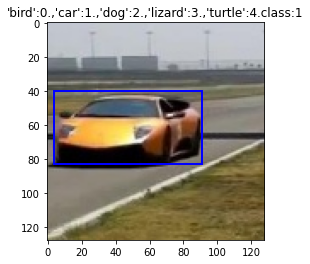

KeyboardInterrupt: Interrupted by user

In [3]:
dataset = Tiny_vid(train=False).set_attrs(batch_size=1, shuffle=True)
class_dict = {'bird':0.,'car':1.,'dog':2.,'lizard':3.,'turtle':4.}
from IPython import display
for x, y in dataset:
    plt.figure()
    ax = plt.imshow(x.squeeze(0))
    test_bbox = np.floor(y[1]*128)
    test_bbox = test_bbox.squeeze(0).tolist()
    ax.axes.add_patch(bbox_to_rect(test_bbox, 'blue'))
    plt.title(f"'bird':0.,'car':1.,'dog':2.,'lizard':3.,'turtle':4.class:{y[0]}")    
    plt.show()
    a = input("aa:")
    if a == '1':
        display.clear_output(wait=True)
        continue
    if a == '2':
        break

In [ ]:
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    import pdb;pdb.set_trace()

    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = np.maximum(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clip(min=0)
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [ ]:
ba = jt.randn((16,4))
bb = jt.randn((16,4))

box_iou(ba,bb)